# importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
#models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report

# Reading Data

In [2]:
rs = 0
df = pd.read_csv(f'MCSDatasetNEXTCONLab.csv')
df['Ligitimacy'] = df['Ligitimacy'].replace(0,-1)
trDf = df[:10139][:]
teDf = df[10139:][:]
trDf = trDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
trDf = trDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
teDf = teDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
teDf = teDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
trY = trDf['Ligitimacy'].values
teY = teDf['Ligitimacy'].values
trX = trDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values
teX = teDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values

In [3]:
trDf

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,4421.4189,-3033.6925,1,4,13,40,40,9,91,0,131380,1
1,1,4421.5414,-3043.6606,1,4,23,40,30,9,91,0,131380,1
2,1,4421.0414,-3039.6326,1,4,33,40,20,9,91,0,121996,1
3,1,4418.6802,-3035.7741,1,4,43,40,10,9,91,0,121996,1
4,2,4477.2690,-1477.2228,2,15,49,30,30,5,47,0,140784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10134,2820,5398.0715,-1363.8483,3,4,50,40,20,1,87,0,290929,1
10135,2820,5404.4717,-1361.2367,3,5,0,40,10,1,87,0,300313,1
10136,2821,5435.2708,-2177.0007,2,19,44,40,40,5,35,0,300303,1
10137,2821,5435.5436,-2178.3546,2,19,54,40,30,5,35,0,300303,1


### biased data
The next line shows that the data is biased, number of data labeled '1' is too much more than the data labeled '-1'

 1    8839
-1    1300
Name: Ligitimacy, dtype: int64


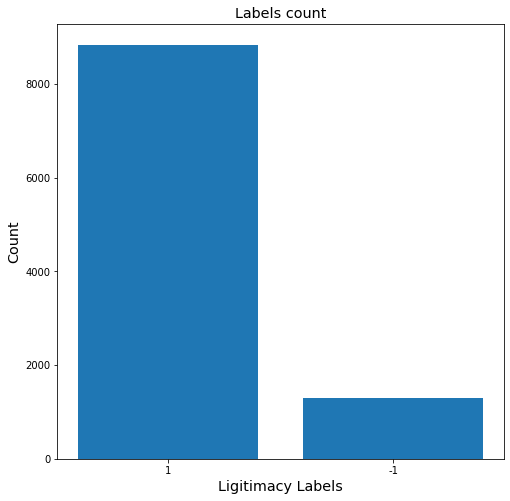

In [4]:
print(trDf['Ligitimacy'].value_counts())
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(['1', '-1'], trDf['Ligitimacy'].value_counts())
plt.title('Labels count', fontsize = 'x-large')
plt.ylabel('Count', fontsize = 'x-large')
plt.xlabel('Ligitimacy Labels', fontsize = 'x-large')
plt.show()


In [5]:
# converting to data frame
xtrain = pd.DataFrame(trX,columns = ["Latitude", "Longitude", "Hour", "Minute", "Duration", "RemainingTime", "Resources", "Coverage", "OnPeakHours", "GridNumber"]) 
xtest = pd.DataFrame(teX,columns = ["Latitude", "Longitude", "Hour", "Minute", "Duration", "RemainingTime", "Resources", "Coverage", "OnPeakHours", "GridNumber"])
ytrain =pd.DataFrame(trY,columns = ["Ligitimacy"])
ytest =pd.DataFrame(teY,columns = ["Ligitimacy"])

In [6]:
xtrain

,Latitude,Longitude,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,4421.4189,-3033.6925,4.0,13.0,40.0,40.0,9.0,91.0,0.0,131380.0
1,4421.5414,-3043.6606,4.0,23.0,40.0,30.0,9.0,91.0,0.0,131380.0
2,4421.0414,-3039.6326,4.0,33.0,40.0,20.0,9.0,91.0,0.0,121996.0
3,4418.6802,-3035.7741,4.0,43.0,40.0,10.0,9.0,91.0,0.0,121996.0
4,4477.2690,-1477.2228,15.0,49.0,30.0,30.0,5.0,47.0,0.0,140784.0
...,...,...,...,...,...,...,...,...,...,...
10134,5398.0715,-1363.8483,4.0,50.0,40.0,20.0,1.0,87.0,0.0,290929.0
10135,5404.4717,-1361.2367,5.0,0.0,40.0,10.0,1.0,87.0,0.0,300313.0
10136,5435.2708,-2177.0007,19.0,44.0,40.0,40.0,5.0,35.0,0.0,300303.0
10137,5435.5436,-2178.3546,19.0,54.0,40.0,30.0,5.0,35.0,0.0,300303.0


### check for null values

In [7]:
print(xtrain.isnull().values.any())
print(xtest.isnull().values.any())
print(ytrain.isnull().values.any())
print(ytest.isnull().values.any())

False
False
False
False


### data correlations

<AxesSubplot:>

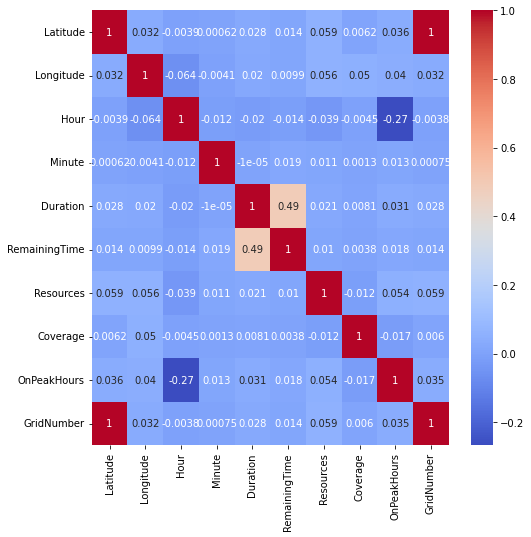

In [8]:
# Plot the coorelation between features
plt.figure(figsize=(8,8))
sns.heatmap(xtrain.corr(), annot = True, cmap = 'coolwarm')

## comment
There are a positive correlation between both GridNumber and Latitude

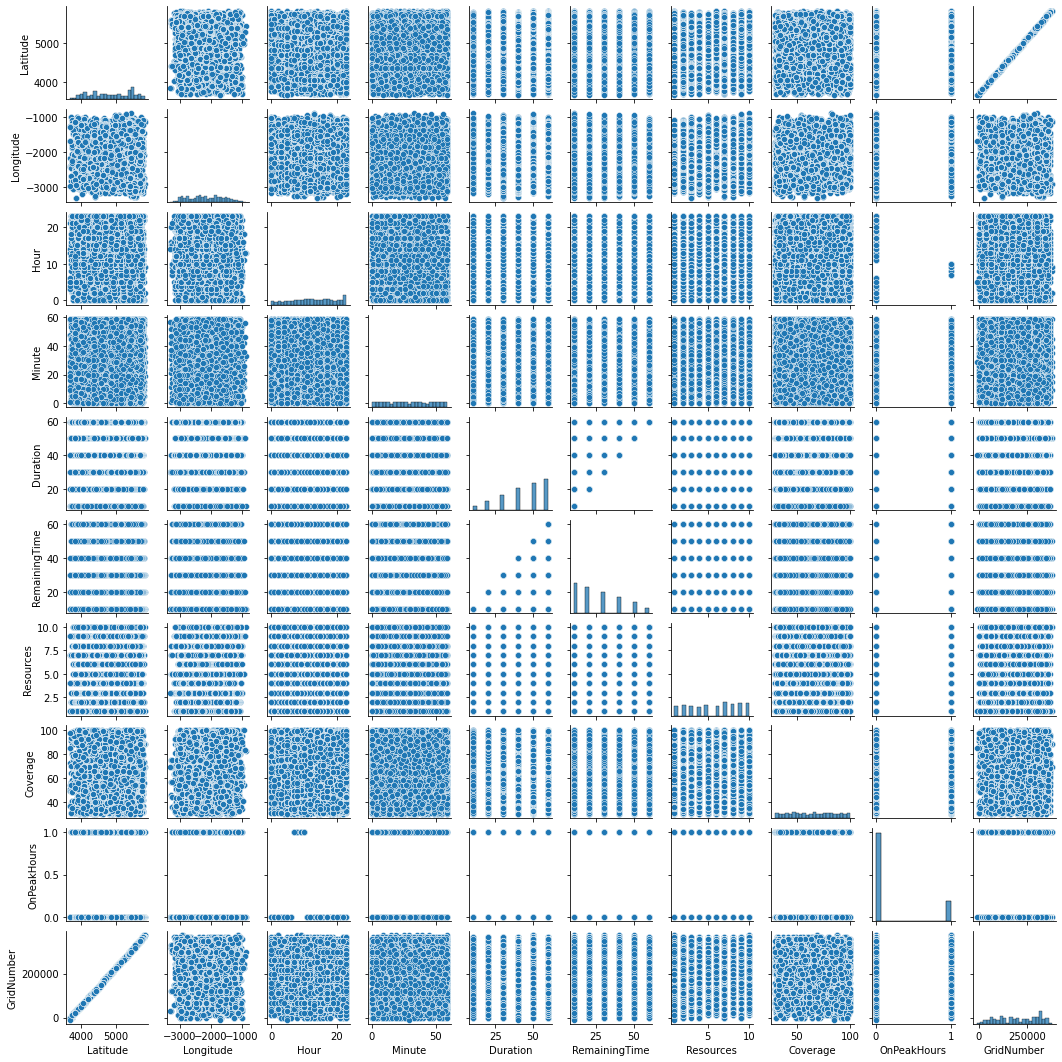

In [9]:
sns.pairplot(xtrain, height = 1.5)

# Functions

In [10]:
def model_Boosting(nEst, lr, x_train, y_train, x_test, y_test):
    classifier = AdaBoostClassifier(n_estimators = nEst, learning_rate = lr, random_state=0)
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'Adaboost: {accuracy}')
    plot_confusion_matrix(classifier, x_test, y_test)

    return classifier, ypred, accuracy

In [11]:
def model_knn(x_train, y_train, x_test, y_test):
    classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #choosing Euclidean distance metric
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'K-NN: {accuracy}')
    plot_confusion_matrix(classifier, x_test, y_test)
    
    return classifier, ypred, accuracy

In [12]:
def model_decisiontree(x_train, y_train, x_test, y_test):
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'Decision Tree: {accuracy}')
    plot_confusion_matrix(classifier, x_test, y_test)
    
    return classifier, ypred, accuracy

In [13]:
# def model_svm(x_train, y_train, x_test, y_test):
#     classifier = SVC(kernel = 'sigmoid', random_state = 0)
#     classifier.fit(x_train, y_train)
#     ypred = classifier.predict(x_test)
#     accuracy = accuracy_score(y_test, ypred)
#     print(accuracy*100)
#     plot_confusion_matrix(classifier, x_test, y_test)
    
#     return classifier, ypred, accuracy

In [14]:
# def model_logisticregression(x_train, y_train, x_test, y_test):
#     classifier = LogisticRegression(random_state = 0)
#     classifier.fit(x_train, y_train)
#     ypred = classifier.predict(x_test)
#     accuracy = accuracy_score(y_test, ypred)
#     print(accuracy*100)
#     plot_confusion_matrix(classifier, x_test, y_test)
    
#     return classifier, ypred, accuracy

In [15]:
def plt_bar(labels_name, yvalues, baseline, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot(labels_name, baseline, color='red', marker='o',
                     linestyle='dashed', label = 'Baseline')
    plt.bar(labels_name, yvalues)
    plt.title(title, fontsize = 'x-large')
    plt.ylabel(ylabel, fontsize = 'x-large')
    plt.xlabel(xlabel, fontsize = 'x-large')
    plt.yticks(np.arange(90, 101, 0.5))
    plt.ylim(ymin = 90)
    ax.set_xlim(xmin = -0.7, xmax = 3)
    plt.hlines(yvalues, xmin = [-0.7, -0.7, -0.7], xmax = [-0.4, 0.6, 1.6], colors = 'black', linestyles='dashed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

In [16]:
def plot_against_Baseline(xvalues, yaxis_values, title):
    colors = []
    plt.figure(figsize=(7,5), dpi=100)        
    axis1 = plt.plot(xvalues, yaxis_values[0], color='red', marker='o',
                     linestyle='dashed', label = 'Baseline')
    axis2 = plt.plot(xvalues, yaxis_values[1], color='green', marker='o', 
                     linestyle='dashed', label = 'over-sampling: SMOTE')
    axis3 = plt.plot(xvalues, yaxis_values[2], color='blue', marker='o', 
                     linestyle='dashed', label = 'over-sampling: ADASYN')
    axis4 = plt.plot(xvalues, yaxis_values[3], color='cyan', marker='o',
                     linestyle='dashed', label = 'Under-sampling: Random Under-sampling')
    
    plt.title(title, fontsize = 'x-large')
    plt.xlabel('Models', fontsize = 'x-large')
    plt.ylabel('Accuracy %', fontsize = 'x-large')
    plt.yticks(np.arange(90, 101, 0.5))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show

In [17]:
def plot_features_vs_accuracy(xvalues, accuracies_values, title, xlabel, ylabel):
    plt.figure(figsize=(7,5), dpi=100)
    axis1 = plt.plot(xvalues, accuracies_values, color='green', marker='o', 
                     linestyle='dashed', label = 'important features')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xvalues)
    plt.yticks(range(80,101))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show

# Implementation

## Baseline estimators

1) I tried to fit the models directly to the data, then dropped one of the correlated columns and refit the models.
by comparing the accuracies, I found that I should not drop the feature, as the accuracy of the models fall down after dropping the "GridNumber" feature

2) Choose the three models that give the best accuracies and use them as baseline estimaotrs
("AdaBoost", "K-NN", "Decision-Tree")

In [18]:
all_accuracies = []
base_accuracies = []

Adaboost: 98.204833141542


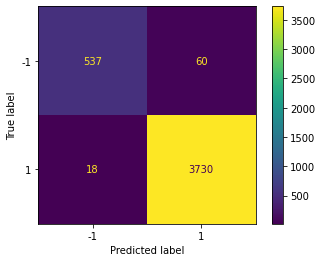

In [19]:
ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, xtrain, ytrain, xtest, ytest)
base_accuracies.append(ada_accuracy)

K-NN: 98.08975834292289


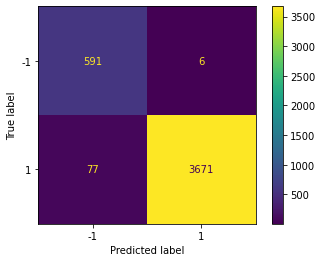

In [20]:
knn_model, knn_pred, knn_accuracy = model_knn(xtrain, ytrain, xtest, ytest)
base_accuracies.append(knn_accuracy)

Decision Tree: 95.35097813578827


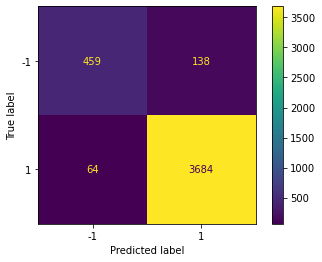

In [21]:
dt_model, dt_pred, dt_accuracy = model_decisiontree(xtrain, ytrain, xtest, ytest)
base_accuracies.append(dt_accuracy)

In [22]:
all_accuracies.append(base_accuracies)

In [23]:
# lr_model, lr_pred, lr_accuracy = model_logisticregression(xtrain, ytrain, xtest, ytest)

In [24]:
# svm_model, svm_pred, svm_accuracy = model_svm(xtrain, ytrain, xtest, ytest)

In [25]:
# # try to drop one of the correlated columns
# new_train_x = xtrain.drop(labels = 'GridNumber', axis = 1)
# new_test_x = xtest.drop(labels = 'GridNumber', axis = 1)

In [26]:
# ada_model_new, ada_pred_new, ada_accuracy_new = model_Boosting(100, 1, new_train_x, ytrain, new_test_x, ytest)

In [27]:
# knn_model, knn_pred, knn_accuracy = model_knn(new_train_x, ytrain, new_test_x, ytest)

In [28]:
# dt_model, dt_pred, dt_accuracy = model_decisiontree(new_train_x, ytrain, new_test_x, ytest)

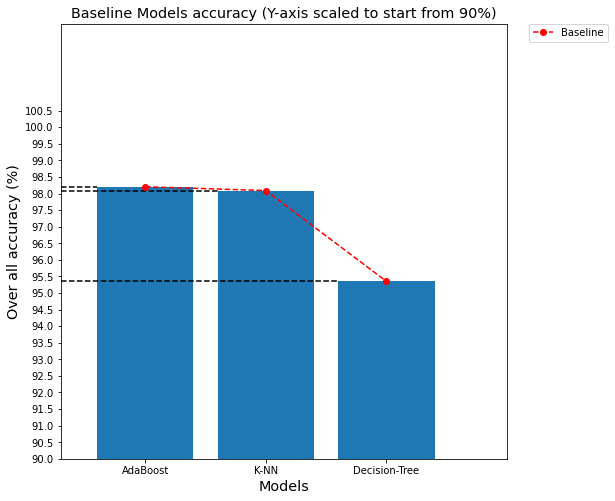

In [29]:
plt_bar(["AdaBoost", "K-NN", "Decision-Tree"], [ada_accuracy, knn_accuracy, dt_accuracy], [ada_accuracy, knn_accuracy, dt_accuracy], "Baseline Models accuracy (Y-axis scaled to start from 90%)", 'Models', 'Over all accuracy (%)')

## Over Sampling
1) Using SMOTE from Imbalanced Learn

2) using ADASYN from Imbalanced Learn

### 1) SMOTE

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
sm = SMOTE(random_state = rs, sampling_strategy = 'minority')
x_res_sm, y_res_sm = sm.fit_resample(xtrain, ytrain)
smote_accuracy = []

Adaboost: 98.13578826237054


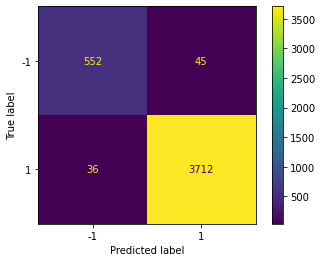

In [32]:
ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, x_res_sm, y_res_sm, xtest, ytest)
smote_accuracy.append(ada_accuracy)

K-NN: 97.76754890678941


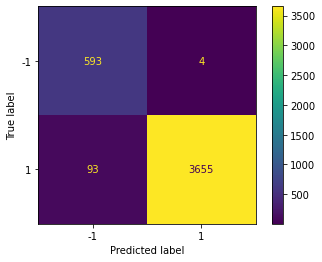

In [33]:
knn_model, knn_pred, knn_accuracy = model_knn(x_res_sm, y_res_sm, xtest, ytest)
smote_accuracy.append(knn_accuracy)

Decision Tree: 94.9367088607595


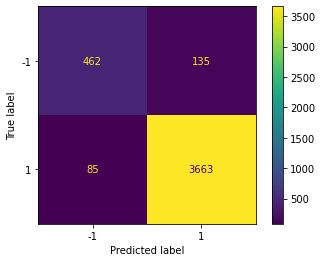

In [34]:
dt_model, dt_pred, dt_accuracy = model_decisiontree(x_res_sm, y_res_sm, xtest, ytest)
smote_accuracy.append(dt_accuracy)

In [35]:
# all_accuracies.append(smote_accuracy)

### 2) ADASYN

In [36]:
# from imblearn.over_sampling import ADASYN

In [37]:
# ads = ADASYN(random_state = rs, sampling_strategy = 'minority')
# x_res_ads, y_res_ads = ads.fit_resample(xtrain, ytrain)
# adasyn_accuracy = []

In [38]:
# ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, x_res_ads, y_res_ads, xtest, ytest)
# adasyn_accuracy.append(ada_accuracy*100)

In [39]:
# knn_model, knn_pred, knn_accuracy = model_knn(x_res_ads, y_res_ads, xtest, ytest)
# adasyn_accuracy.append(knn_accuracy*100)

In [40]:
# dt_model, dt_pred, dt_accuracy = model_decisiontree(x_res_ads, y_res_ads, xtest, ytest)
# adasyn_accuracy.append(dt_accuracy*100)

In [41]:
# all_accuracies.append(adasyn_accuracy)

## under-sampling
using Random Undersampling from Imbalance Learn

In [42]:
# from imblearn.under_sampling import RandomUnderSampler

In [43]:
# rus = RandomUnderSampler(random_state = rs, sampling_strategy = 'majority')
# x_res_rus, y_res_rus = rus.fit_resample(xtrain, ytrain)
# random_accuracy = []

In [44]:
# ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, x_res_rus, y_res_rus, xtest, ytest)
# random_accuracy.append(ada_accuracy*100)

In [45]:
# knn_model, knn_pred, knn_accuracy = model_knn(x_res_rus, y_res_rus, xtest, ytest)
# random_accuracy.append(knn_accuracy*100)

In [46]:
# dt_model, dt_pred, dt_accuracy = model_decisiontree(x_res_rus, y_res_rus, xtest, ytest)
# random_accuracy.append(dt_accuracy*100)

In [47]:
# all_accuracies.append(random_accuracy)

In [48]:
# plot_against_Baseline(['Adaboost', 'KNN', 'Decision Tree'], all_accuracies, 'Comparing Accuracies')

Choosing the over-samplping "SMOTE" technique to continue with during later work

In [49]:
# plt_bar(['Adaboost', 'KNN', 'Decision Tree'], smote_accuracy, base_accuracies,'Change in performance after applying over sampling',
#         'Models', 'Accuracies')

## applying feature selection and dimensionality reduction

### RFE

In [50]:
from sklearn.feature_selection import RFE

### Applying RFE with adaboost model

Adaboost: 97.56041426927503
Adaboost: 97.81357882623706
Adaboost: 97.72151898734177
Adaboost: 97.90563866513233
Adaboost: 98.25086306098964
Adaboost: 98.36593785960875
Adaboost: 98.204833141542


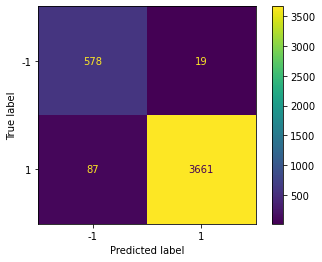

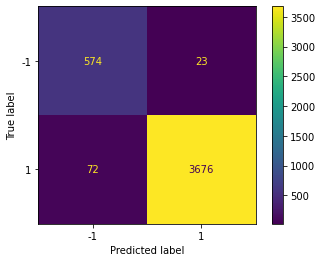

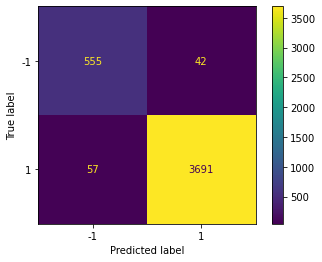

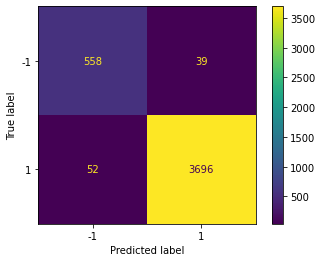

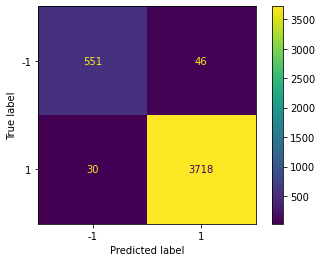

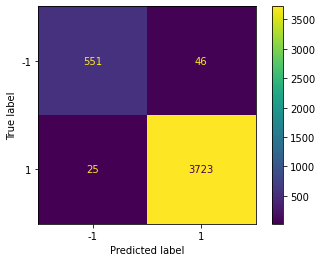

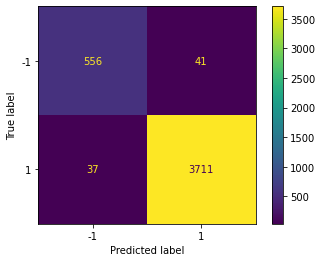

In [51]:
rfe_accuracy = []
ada_selector_accuracy = []
for i in range(3, 10):
    selector = RFE(ada_model, n_features_to_select = i, step=1)
    selector.fit(x_res_sm, y_res_sm)
    selector_train = selector.transform(x_res_sm)
    selector_test = selector.transform(xtest)
    ada_model_selector, ada_pred, ada_accuracy = model_Boosting(400, 1, selector_train, y_res_sm, selector_test, ytest)
    ada_selector_accuracy.append(ada_accuracy)
    
rfe_accuracy.append(ada_selector_accuracy)

### applying RFE with KNN

Knn is not support the feature selection in scikit learn, So, I cannot use RFE with KNN

In [52]:
rfe_accuracy.append([0, 0, 0, 0, 0, 0, 0])

In [53]:
# knn_model = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #choosing Euclidean distance metric
# knn_model.fit(x_res_sm, y_res_sm)

In [54]:
# knn_selector_accuracy = []
# for i in range(3, 10):
#     selector = RFE(knn_model, n_features_to_select = i, step=1)
#     selector.fit(x_res_sm, y_res_sm)
#     selector_train = selector.transform(x_res_sm)
#     selector_test = selector.transform(xtest)
#     knn_model_selector, knn_pred, knn_accuracy = model_knn(selector_train, y_res_sm, selector_test, ytest)
#     knn_selector_accuracy.append(knn_accuracy)

### Applying RFE with Decision tree

Decision Tree: 97.99769850402762
Decision Tree: 98.34292289988493
Decision Tree: 97.65247410817031
Decision Tree: 96.34062140391254
Decision Tree: 95.92635212888378
Decision Tree: 95.00575373993095
Decision Tree: 95.14384349827388


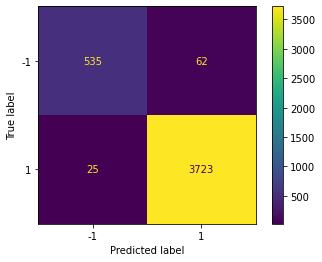

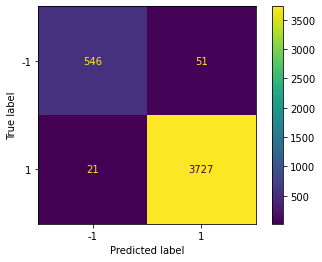

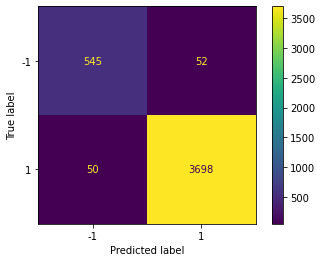

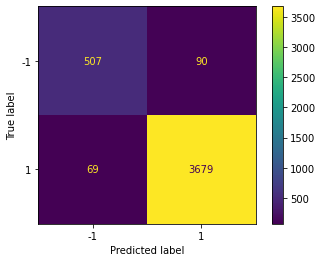

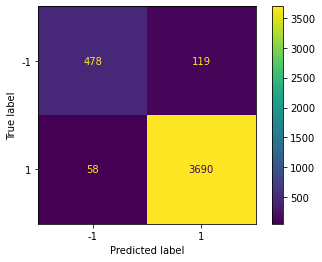

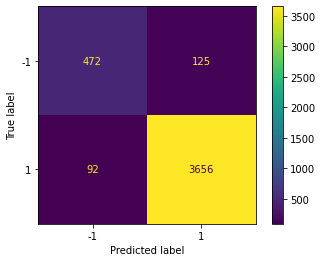

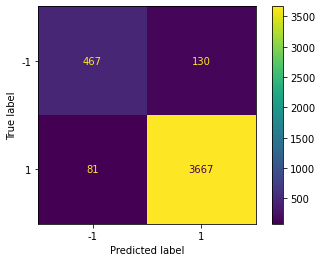

In [55]:
dt_selector_accuracy = []
for i in range(3, 10):
    selector = RFE(dt_model, n_features_to_select = i, step=1)
    selector.fit(x_res_sm, y_res_sm)
    selector_train = selector.transform(x_res_sm)
    selector_test = selector.transform(xtest)
    dt_model_selector, dt_pred, dt_accuracy = model_decisiontree(selector_train, y_res_sm, selector_test, ytest)
    dt_selector_accuracy.append(dt_accuracy)
rfe_accuracy.append(dt_selector_accuracy)

### Using RandomForest to determine the feature importance

In [56]:
from sklearn.ensemble import RandomForestClassifier
ran_accuracy = []

In [57]:
def model_Randomforest(nEst, x_train, y_train, x_test, y_test):
    model = RandomForestClassifier(n_estimators = nEst, random_state = 0)
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    importance = model.feature_importances_ 
    y_pred = model.predict(x_test)
    
    return importance

In [58]:
importance = model_Randomforest(5, x_res_sm, y_res_sm, xtest, ytest)

In [59]:
importance_sorted_indices = np.argsort(importance)[::-1]
importance_sorted_indices

array([6, 2, 0, 1, 9, 8, 4, 7, 5, 3], dtype=int64)

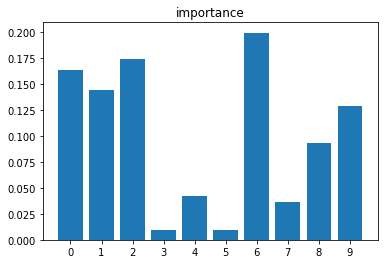

In [60]:
def plot_importance(importance, title):
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    #list(range(len(importance)))
    plt.xticks([x for x in range(len(importance))])
    plt.title(title)
    plt.show()
    
plot_importance(importance, "importance")

In [61]:
feature_list = []
for i in range(3,10):
    feature_list.append(importance_sorted_indices[:i])

Adaboost: 91.78365937859608
Adaboost: 96.13348676639816
Adaboost: 98.06674338319908
Adaboost: 97.95166858457998
Adaboost: 98.38895281933256
Adaboost: 98.48101265822785
Adaboost: 98.204833141542


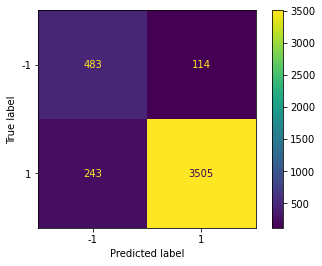

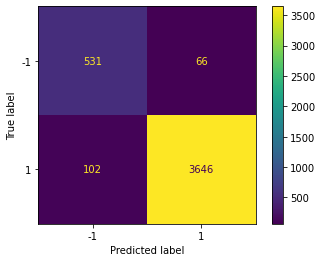

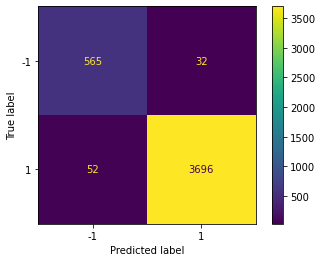

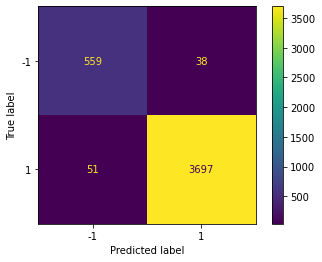

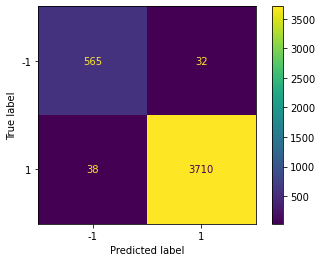

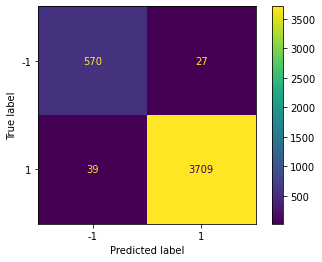

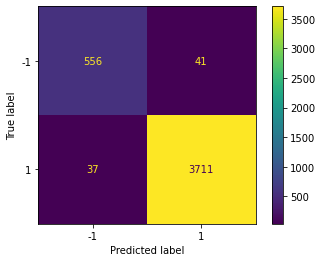

In [62]:
ada_selector_accuracy = []
for i in feature_list:
    ada_model_selector, ada_pred, ada_accuracy = model_Boosting(400, 1, x_res_sm.iloc[:, i], y_res_sm, xtest.iloc[:, i], ytest)
    ada_selector_accuracy.append(ada_accuracy)
ran_accuracy.append(ada_selector_accuracy)

K-NN: 90.77100115074799
K-NN: 98.45799769850403
K-NN: 98.41196777905638
K-NN: 98.41196777905638
K-NN: 97.99769850402762
K-NN: 97.9746835443038
K-NN: 97.8596087456847


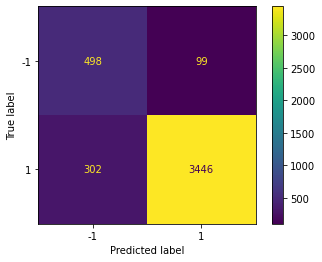

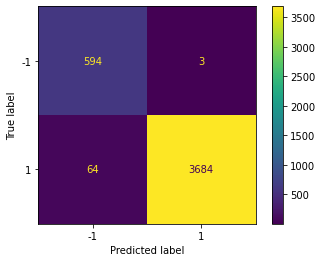

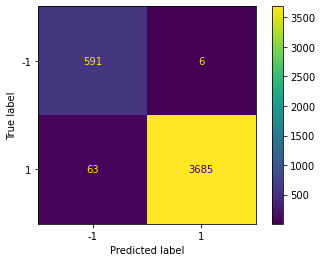

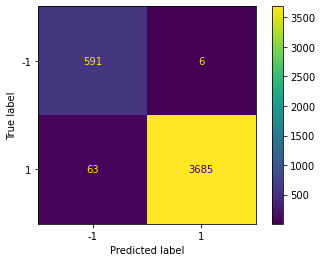

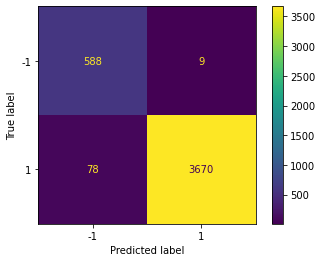

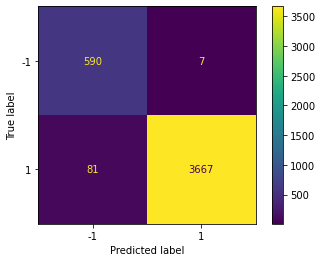

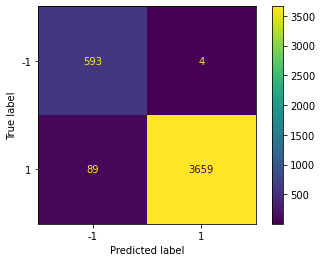

In [63]:
knn_selector_accuracy = []
for i in feature_list:
    knn_model_selector, knn_pred, knn_accuracy = model_knn(x_res_sm.iloc[:, i], y_res_sm, xtest.iloc[:, i], ytest)
    knn_selector_accuracy.append(knn_accuracy)
ran_accuracy.append(knn_selector_accuracy)

Decision Tree: 90.58688147295743
Decision Tree: 95.62715765247411
Decision Tree: 96.47871116225546
Decision Tree: 96.50172612197927
Decision Tree: 95.58112773302648
Decision Tree: 94.84464902186421
Decision Tree: 94.84464902186421


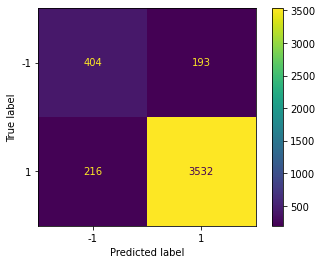

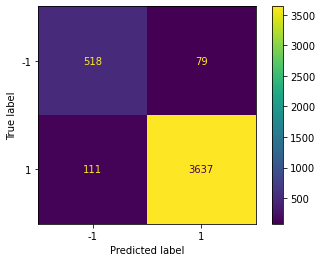

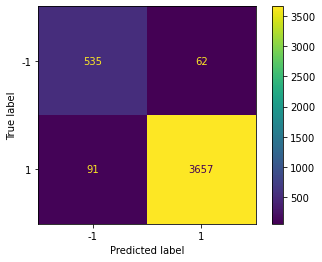

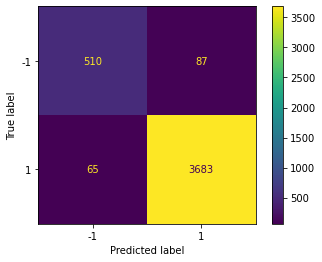

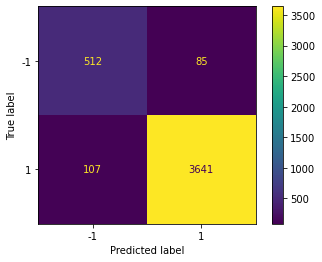

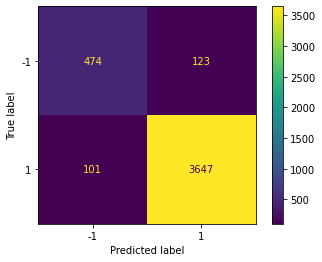

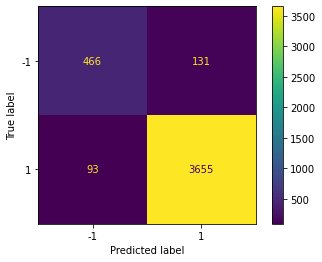

In [64]:
dt_selector_accuracy = []
for i in feature_list:
    dt_model_selector, dt_pred, dt_accuracy = model_decisiontree(x_res_sm.iloc[:, i], y_res_sm, xtest.iloc[:, i], ytest)
    dt_selector_accuracy.append(dt_accuracy)
ran_accuracy.append(dt_selector_accuracy)

### PCA dimensionality reduction

In [65]:
from sklearn.decomposition import PCA

In [66]:
pca_accuracy = []

### Applying PCA with AdaBoost

Adaboost: 97.28423475258919
Adaboost: 97.37629459148447
Adaboost: 97.5373993095512
Adaboost: 97.35327963176064
Adaboost: 97.56041426927503
Adaboost: 97.81357882623706
Adaboost: 98.15880322209436


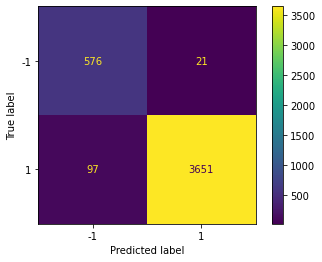

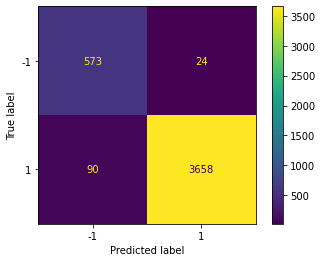

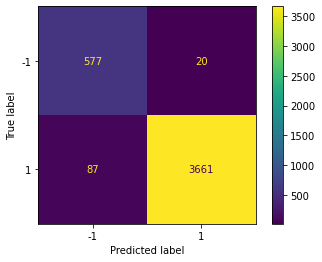

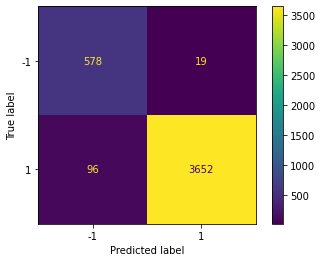

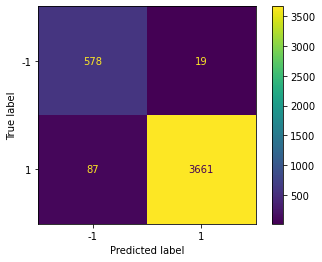

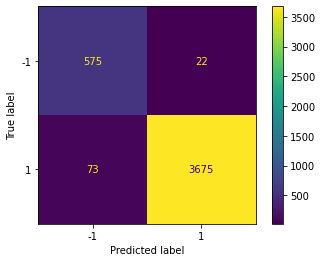

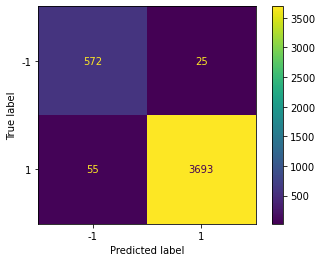

In [67]:
ada_pca_accuracy = []
for i in range(3, 10):
    pca = PCA(n_components = i)
    pca_train = pca.fit_transform(x_res_sm)
    pca_test = pca.transform(xtest)
    ada_model_pca, ada_pred, ada_accuracy = model_Boosting(400, 1, pca_train, y_res_sm, pca_test, ytest)
    ada_pca_accuracy.append(ada_accuracy)
pca_accuracy.append(ada_pca_accuracy)

### Applying PCA with KNN

K-NN: 97.65247410817031
K-NN: 97.60644418872268
K-NN: 97.44533947065592
K-NN: 97.81357882623706
K-NN: 97.81357882623706
K-NN: 97.74453394706559
K-NN: 97.76754890678941


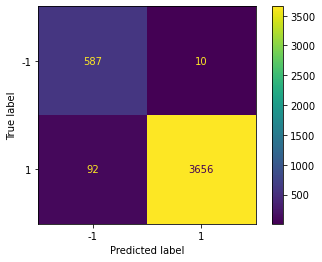

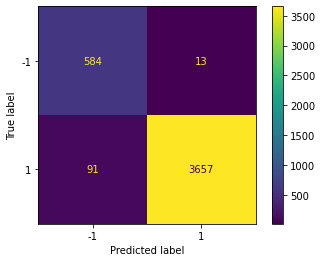

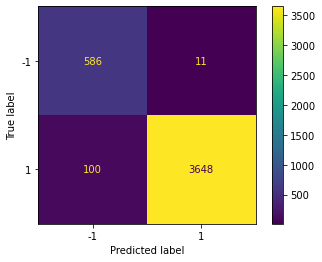

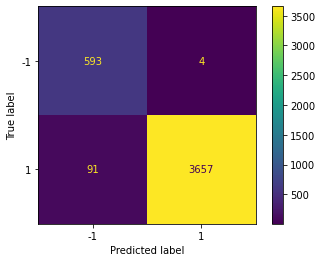

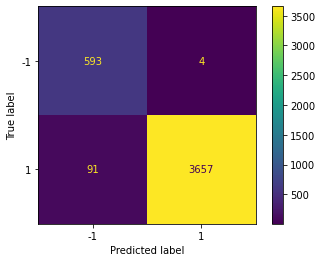

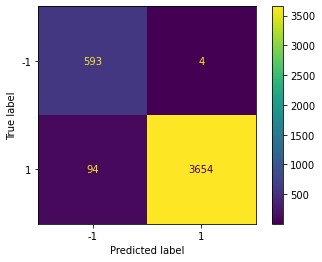

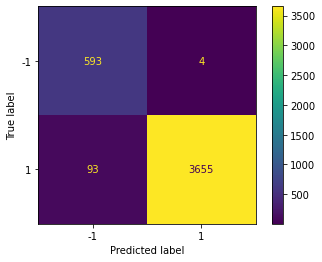

In [68]:
knn_pca_accuracy = []
for i in range(3, 10):
    pca = PCA(n_components = i)
    pca_train = pca.fit_transform(x_res_sm)
    pca_test = pca.transform(xtest)
    knn_model_pca, knn_pred, knn_accuracy = model_knn(pca_train, y_res_sm, pca_test, ytest)
    knn_pca_accuracy.append(knn_accuracy)
pca_accuracy.append(knn_pca_accuracy)

Decision Tree: 98.66513233601842
Decision Tree: 98.4349827387802
Decision Tree: 98.25086306098964
Decision Tree: 98.36593785960875
Decision Tree: 98.34292289988493
Decision Tree: 97.19217491369389
Decision Tree: 95.14384349827388


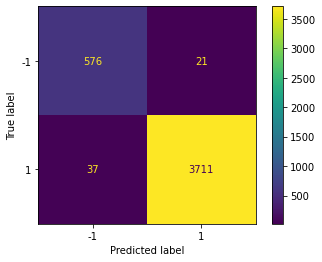

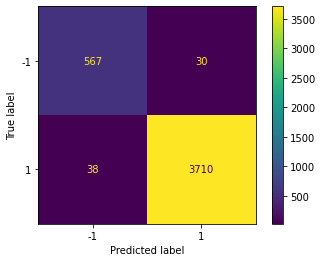

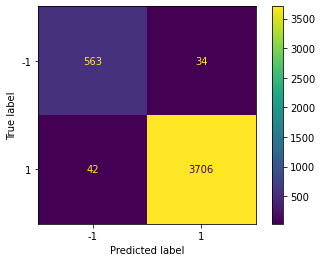

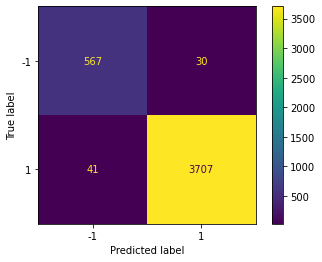

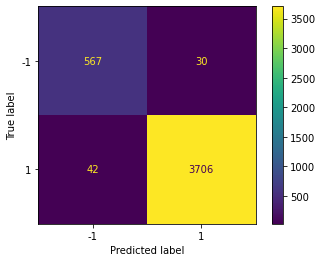

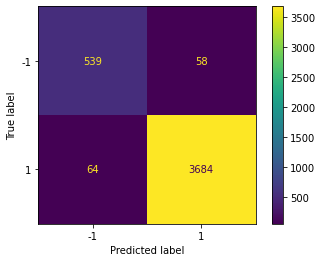

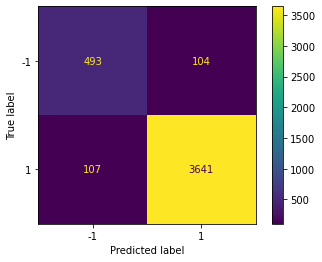

In [69]:
dt_pca_accuracy = []
for i in range(3, 10):
    pca = PCA(n_components = i)
    pca_train = pca.fit_transform(x_res_sm)
    pca_test = pca.transform(xtest)
    dt_model_pca, dt_pred, dt_accuracy = model_decisiontree(pca_train, y_res_sm, pca_test, ytest)
    dt_pca_accuracy.append(dt_accuracy)
pca_accuracy.append(dt_pca_accuracy)

In [70]:
feature_selection_accuracy = [rfe_accuracy, ran_accuracy, pca_accuracy]

In [71]:
i = 0
feature_selection_accuracy[0][i+1]

[0, 0, 0, 0, 0, 0, 0]

In [72]:
feature_selection_accuracy

[[[97.56041426927503,
   97.81357882623706,
   97.72151898734177,
   97.90563866513233,
   98.25086306098964,
   98.36593785960875,
   98.204833141542],
  [0, 0, 0, 0, 0, 0, 0],
  [97.99769850402762,
   98.34292289988493,
   97.65247410817031,
   96.34062140391254,
   95.92635212888378,
   95.00575373993095,
   95.14384349827388]],
 [[91.78365937859608,
   96.13348676639816,
   98.06674338319908,
   97.95166858457998,
   98.38895281933256,
   98.48101265822785,
   98.204833141542],
  [90.77100115074799,
   98.45799769850403,
   98.41196777905638,
   98.41196777905638,
   97.99769850402762,
   97.9746835443038,
   97.8596087456847],
  [90.58688147295743,
   95.62715765247411,
   96.47871116225546,
   96.50172612197927,
   95.58112773302648,
   94.84464902186421,
   94.84464902186421]],
 [[97.28423475258919,
   97.37629459148447,
   97.5373993095512,
   97.35327963176064,
   97.56041426927503,
   97.81357882623706,
   98.15880322209436],
  [97.65247410817031,
   97.60644418872268,
   97.

In [73]:
labels = [['adaboost with RFE', 'KNN with RFE', 'Decision tree With RFE'],
         ['adaboost with Randomforest', 'KNN with Randomforest', 'Decision tree With Randomforest'],
         ['adaboost with PCA', 'KNN with PCA', 'Decision tree With PCA']]
colors = [['#4ADEDE', '#1AA7ec', '#1E2F97'],
          ['#97CF8A', '#7A9F79', 'green'],
          ['#8B008C', '#CC00CD', '#FF00FE']]

In [90]:
def plot_against_Baseline(xvalues, yaxis_values, title):
    colors = []
    plt.figure(figsize=(10,10), dpi=100)
    
    #plotting the accuracies obtained from RFE
    rfe = yaxis_values[0]
    plt.plot(xvalues, rfe[0], color='#4ADEDE', marker='o',
            linestyle='dashed', label = 'Adaboost with RFE')
    plt.plot(xvalues, rfe[1], color='#1AA7ec', marker='o', 
            linestyle='dashed', label = 'KNN with RFE')
    plt.plot(xvalues, rfe[2], color='#1E2F97', marker='o', 
            linestyle='dashed', label = 'Decisiontree with RFE')
    
    #plotting the accuracies obtained from RandomForest
    rand = yaxis_values[1]
    plt.plot(xvalues, rand[0], color='#8B008C', marker='o',
            linestyle='dashed', label = 'Adaboost with Random forest')
    plt.plot(xvalues, rand[1], color='#CC00CD', marker='o', 
            linestyle='dashed', label = 'KNN with Random forest')
    plt.plot(xvalues, rand[2], color='#FF00FE', marker='o', 
            linestyle='dashed', label = 'Decisiontree with Random forest')
    
    #plotting the accuracies obtained from PCA
    pca = yaxis_values[2]
    plt.plot(xvalues, pca[0], color='#97CF8A', marker='o',
            linestyle='dashed', label = 'Adaboost with pca')
    plt.plot(xvalues, pca[1], color='#7A9F79', marker='o', 
            linestyle='dashed', label = 'KNN with pca')
    plt.plot(xvalues, pca[2], color='green', marker='o', 
            linestyle='dashed', label = 'Decisiontree with pca')
    
    plt.title(title, fontsize = 'x-large')
    plt.xlabel('Models', fontsize = 'x-large')
    plt.ylabel('Accuracy %', fontsize = 'x-large')
    plt.yticks(np.arange(90, 101, 0.5))
    plt.ylim(ymin = 90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show

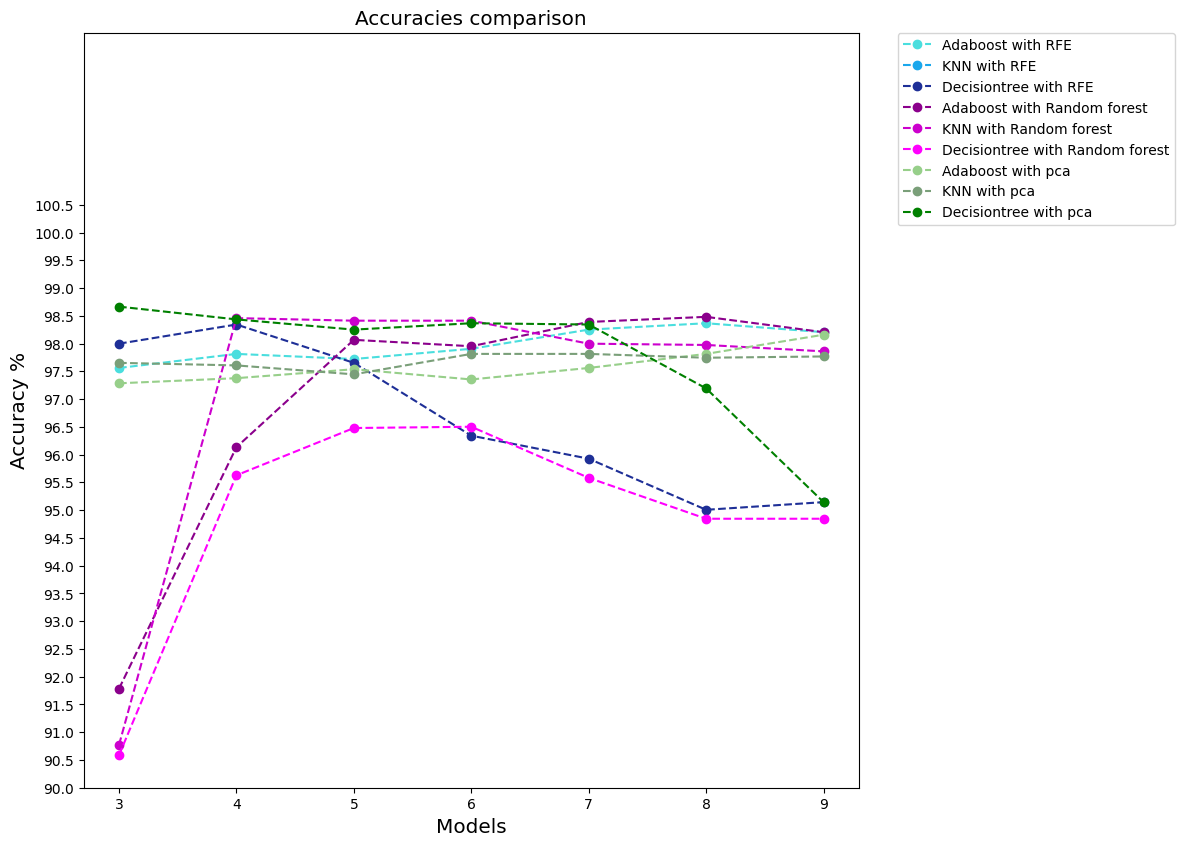

In [91]:
plot_against_Baseline(np.arange(3,10,1), feature_selection_accuracy, "Accuracies comparison")

#### conclusion
Since that KNN is not support feature selection and I cannot obtain a result using them both, so I cannot complete the rest with using both of them together.
So, the comparison is really between both Random Forest and PCA. by looking to the graph plotted above, PCA gives a better overall accuracy.
So, I will complete the rest of the project using it.